To downlaod data set and final model,visit:
    https://www.kaggle.com/anasiri/food-classifier

In [2]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import h5py
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Activation,MaxPool2D,Dropout,Dense,Flatten,Input,BatchNormalization
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from matplotlib import pyplot as plt
from IPython.display import clear_output
from PIL import Image
import warnings
warnings.filterwarnings('ignore','FutureWarnings')

The direction should include images

In [4]:
train_dir = './train'
test_dir = './test'
epochs = 20
batch_size = 16
train_size = 90900
val_size = 10100
img_width, img_height = 224, 224

This cell separates images to test and validation

In [5]:
import math
import os
import random
import shutil
from collections import defaultdict
from os.path import abspath, join, basename, exists


def get_containing_folder_name(path):
    # dirname has inconsistent behavior when path has a trailing slash
    full_containing_path = abspath(join(path, os.pardir))
    return basename(full_containing_path)

def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct,
                                           stratify=True, seed=None):
    prev_state = None
    if seed:
        prev_state = random.getstate()
        random.seed(seed)

    # Recreate testing and training directories
    if testing_data_dir.count('/') > 1:
        shutil.rmtree(testing_data_dir, ignore_errors=False)
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory", testing_data_dir)
    else:
        print(
            testing_data_dir, "not empty, did not remove contents")

    if training_data_dir.count('/') > 1:
        shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory", training_data_dir)
    else:
        print(training_data_dir, "not empty, did not remove contents")

    files_per_class = defaultdict(list)

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = basename(subdir)

        # Don't create a subdirectory for the root directories
        if category_name in map(basename, [all_data_dir, training_data_dir, testing_data_dir]):
            continue

        # filtered past top-level dirs, now we're in a category dir
        files_per_class[category_name].extend([join(abspath(subdir), file) for file in files])

    # keep track of train/validation split for each category
    split_per_category = defaultdict(lambda: defaultdict(int))
    # create train/validation directories for each class
    class_directories_by_type = defaultdict(lambda: defaultdict(str))
    for category in files_per_class.keys():
        training_data_category_dir = join(training_data_dir, category)
        if not exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)
        class_directories_by_type['train'][category] = training_data_category_dir

        testing_data_category_dir = join(testing_data_dir, category)
        if not exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
        class_directories_by_type['validation'][category] = testing_data_category_dir

    if stratify:
        for category, files in files_per_class.items():

            random.shuffle(files)
            last_index = math.ceil(len(files) * testing_data_pct)
            for file in files[:last_index]:
                testing_data_category_dir = class_directories_by_type['validation'][category]
                shutil.move(file, join(testing_data_category_dir, basename(file)))
                split_per_category['validation'][category] += 1
            for file in files[last_index:]:
                training_data_category_dir = class_directories_by_type['train'][category]
                shutil.move(file, join(training_data_category_dir, basename(file)))
                split_per_category['train'][category] += 1

    else:  
        files = []
        for file_list in files_per_class.values():
            files.extend(file_list)

        random.shuffle(files)
        last_index = math.ceil(len(files) * testing_data_pct)
        for file in files[:last_index]:
            category = get_containing_folder_name(file)
            directory = class_directories_by_type['validation'][category]
            shutil.move(file, join(directory, basename(file)))
            split_per_category['validation'][category] += 1
        for file in files[last_index:]:
            category = get_containing_folder_name(file)
            directory = class_directories_by_type['train'][category]
            shutil.move(file, join(directory, basename(file)))
            split_per_category['train'][category] += 1
 
    if seed:
        random.setstate(prev_state)
    return split_per_category

You need to run it for the first time.It may take a few minutes.

In [4]:
split_dataset_into_test_and_train_sets('images','train','test',0.1)

test not empty, did not remove contents
train not empty, did not remove contents


defaultdict(<function __main__.split_dataset_into_test_and_train_sets.<locals>.<lambda>()>,
            {'validation': defaultdict(int,
                         {'apple_pie': 100,
                          'baby_back_ribs': 100,
                          'baklava': 100,
                          'beef_carpaccio': 100,
                          'beef_tartare': 100,
                          'beet_salad': 100,
                          'beignets': 100,
                          'bibimbap': 100,
                          'bread_pudding': 100,
                          'breakfast_burrito': 100,
                          'bruschetta': 100,
                          'caesar_salad': 100,
                          'cannoli': 100,
                          'caprese_salad': 100,
                          'carrot_cake': 100,
                          'ceviche': 100,
                          'cheesecake': 100,
                          'cheese_plate': 100,
                          'chicken_curry

Train, test and validation generators.

In [6]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [7]:
train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 90900 images belonging to 101 classes.


In [8]:
test_gen = ImageDataGenerator(
    rescale=1./255)

In [9]:
validation_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size ,
    class_mode='categorical')

Found 10100 images belonging to 101 classes.


In [10]:
train_generator_no_aug = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 90900 images belonging to 101 classes.


I used resnet50 with no top for transfer learning.

In [8]:
model = tf.keras.applications.ResNet50(include_top=False,weights='resnet50_weights_notop.h5',input_tensor=Input(shape=(224,224,3)))

C:\ProgramData\Anaconda3\envs\deep_tf2\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


I freezed every layer except batch normaliztion layers.If you freeze these layers when you are using keras impelemention
of Batch norm you will have problems.

See below:
https://forums.fast.ai/t/frozen-batchnorm-issues-in-transfer-learning/42673

In [10]:
for layer in model.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
            layer.trainable = True
        else:
            layer.trainable = False

Adding my own layers

In [11]:
last_layer = model.layers[-21].output

new_model = Conv2D(32, (3,3), activation = 'relu')(last_layer)
new_model = MaxPooling2D(2,2)(new_model)
new_model = BatchNormalization(axis=-1)(new_model)

new_model = Flatten()(new_model)


new_model = Dense(4096, activation='relu')(new_model)
new_model = Dropout(0.2)(new_model)
new_model = Dense(2048, activation='relu')(new_model)
new_model = Dropout(0.20)(new_model)
new_model = Dense(1024, activation='relu')(new_model)
new_model = Dropout(0.2)(new_model)
new_model = Dense(1024, activation='relu')(new_model)
new_model = Dropout(0.15)(new_model)

new_model = Dense(101, activation='softmax')(new_model)

model = Model(inputs=model.input,outputs=new_model)

W1005 21:04:06.621300  1168 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

To the training...
I strongly recommend that you skip this part becuase I changed things like learning rate in the process of learning.
I will share the final model if you need it.

In [9]:
learning_rate = 0.000001
decay_rate = learning_rate / 16

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(opt,loss,['accuracy'])

In [24]:
filepath="./model-{epoch:02d}a.h5"
mc = K.callbacks.ModelCheckpoint(filepath,'val_accuracy', period=1)

W1007 11:04:35.388478  3480 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [15]:
model.fit_generator(train_generator,train_size/batch_size,epochs,
                        validation_data=validation_generator,validation_steps=val_size/batch_size,callbacks=[mc])


Epoch 1/20
5682/5681 [==============================] - 2461s 433ms/step - loss: 3.3419 - acc: 0.2018 - val_loss: 2.6010 - val_acc: 0.3584
Epoch 2/20
5682/5681 [==============================] - 2005s 353ms/step - loss: 2.6638 - acc: 0.3468 - val_loss: 2.2814 - val_acc: 0.4280
Epoch 3/20
5682/5681 [==============================] - 2002s 352ms/step - loss: 2.4230 - acc: 0.4009 - val_loss: 2.0386 - val_acc: 0.4818
Epoch 4/20
5682/5681 [==============================] - 2003s 352ms/step - loss: 2.2798 - acc: 0.4365 - val_loss: 2.0508 - val_acc: 0.4833
Epoch 5/20
5682/5681 [==============================] - 2003s 353ms/step - loss: 2.1944 - acc: 0.4572 - val_loss: 1.9659 - val_acc: 0.5098
Epoch 6/20
5682/5681 [==============================] - 2003s 353ms/step - loss: 2.1365 - acc: 0.4732 - val_loss: 1.9129 - val_acc: 0.5296
Epoch 7/20
5682/5681 [==============================] - 2111s 372ms/step - loss: 2.0919 - acc: 0.4842 - val_loss: 1.8442 - val_acc: 0.5442
Epoch 8/20
5682/5681 [=====

KeyboardInterrupt: 

In [30]:
model.fit_generator(train_generator,train_size/batch_size,3,
                        validation_data=validation_generator,validation_steps=val_size/batch_size,callbacks=[mc])


Epoch 1/3
5682/5681 [==============================] - 3375s 594ms/step - loss: 1.7642 - accuracy: 0.5628 - val_loss: 1.5585 - val_accuracy: 0.6081
Epoch 2/3
5682/5681 [==============================] - 3095s 545ms/step - loss: 1.6942 - accuracy: 0.5802 - val_loss: 1.5324 - val_accuracy: 0.6159
Epoch 3/3
  88/5681 [..............................] - ETA: 43:28 - loss: 1.6988 - accuracy: 0.5895

KeyboardInterrupt: 

In [10]:
model.fit_generator(train_generator,train_size/batch_size,2,
                        validation_data=validation_generator,validation_steps=val_size/batch_size,callbacks=[mc])


Epoch 1/2
5682/5681 [==============================] - 3598s 633ms/step - loss: 1.6744 - accuracy: 0.5839 - val_loss: 1.5155 - val_accuracy: 0.6182
Epoch 2/2
5682/5681 [==============================] - 2931s 516ms/step - loss: 1.6507 - accuracy: 0.5881 - val_loss: 1.5032 - val_accuracy: 0.6221


In [ ]:
model.fit_generator(train_generator,train_size/batch_size,2,
                        validation_data=validation_generator,validation_steps=val_size/batch_size,callbacks=[mc])


Epoch 1/2
5682/5681 [==============================] - 2584s 455ms/step - loss: 1.4897 - accuracy: 0.6241 - val_loss: 1.4216 - val_accuracy: 0.6426
Epoch 2/2
4935/5681 [=========================>....] - ETA: 4:50 - loss: 1.4653 - accuracy: 0.6292

In [ ]:
model.fit_generator(train_generator,train_size/batch_size,2,
                        validation_data=validation_generator,validation_steps=val_size/batch_size)

Epoch 1/2
 806/5681 [===>..........................] - ETA: 1:09:39 - loss: 1.6220 - accuracy: 0.5992

Now to the final model...

In [11]:
model = load_model('./model-02z.h5')

W0313 21:49:06.265721 100968 deprecation.py:323] From C:\ProgramData\Anaconda3\envs\deep_tf2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Simple function for showing results and confident rate.

In [14]:
def print_res(pred,n,img,actual=None):
    top_n = pred.argsort()[-n:][::-1]
    percentage =np.sort(pred)[::-1] 
    if actual:print('actual:\t\t' + new_dict[actual]+'\n')   
    for i in range(n):
        print ('predict {}:\t'.format(i+1)+new_dict[top_n[i]]+'\npercentage:\t{0:.3f} %'.format(percentage[i]*100))
    plt.imshow(img)

In [15]:
classes = dict([(value, key) for key, value in validation_generator.class_indices.items()]) 

In [46]:
x_batch, y_batch = next(validation_generator)

In [47]:
pred = model.predict(x_batch)

Testing some images:

actual:		french_fries

predict 1:	french_fries
percentage:	93.170 %
predict 2:	churros
percentage:	4.767 %
predict 3:	onion_rings
percentage:	0.796 %
predict 4:	fish_and_chips
percentage:	0.479 %
predict 5:	grilled_cheese_sandwich
percentage:	0.403 %


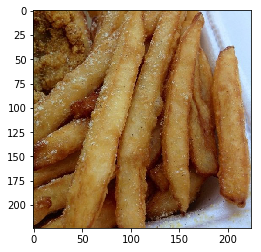

In [68]:
i = 0
n = 5
print_res(pred[i],n,x_batch[i],np.argmax(y_batch[i]))

actual:		cup_cakes

predict 1:	cup_cakes
percentage:	99.980 %
predict 2:	red_velvet_cake
percentage:	0.020 %
predict 3:	cheesecake
percentage:	0.000 %
predict 4:	carrot_cake
percentage:	0.000 %
predict 5:	deviled_eggs
percentage:	0.000 %


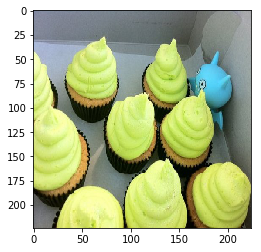

In [69]:
i = 1
print_res(pred[i],n,x_batch[i],np.argmax(y_batch[i]))

actual:		baby_back_ribs

predict 1:	baby_back_ribs
percentage:	91.225 %
predict 2:	steak
percentage:	5.404 %
predict 3:	prime_rib
percentage:	1.858 %
predict 4:	pork_chop
percentage:	0.693 %
predict 5:	peking_duck
percentage:	0.295 %


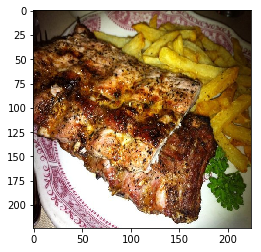

In [70]:
i = 2
print_res(pred[i],n,x_batch[i],np.argmax(y_batch[i]))

actual:		takoyaki

predict 1:	chicken_curry
percentage:	18.564 %
predict 2:	lobster_bisque
percentage:	14.909 %
predict 3:	clam_chowder
percentage:	8.983 %
predict 4:	hummus
percentage:	6.068 %
predict 5:	french_onion_soup
percentage:	4.408 %


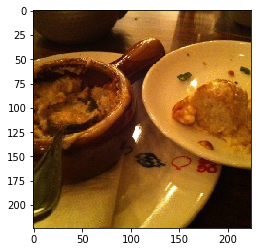

In [71]:
i = 3
print_res(pred[i],n,x_batch[i],np.argmax(y_batch[i]))

actual:		pad_thai

predict 1:	pad_thai
percentage:	69.965 %
predict 2:	fried_rice
percentage:	9.764 %
predict 3:	spaghetti_bolognese
percentage:	5.990 %
predict 4:	chicken_curry
percentage:	1.905 %
predict 5:	paella
percentage:	1.540 %


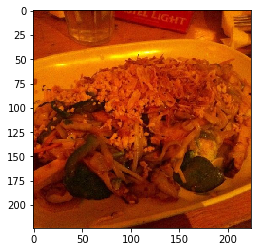

In [72]:
i = 4
print_res(pred[i],n,x_batch[i],np.argmax(y_batch[i]))

Some images from google

predict 1:	pizza
percentage:	82.106 %
predict 2:	paella
percentage:	2.270 %
predict 3:	bruschetta
percentage:	2.137 %
predict 4:	lasagna
percentage:	1.899 %
predict 5:	nachos
percentage:	1.439 %


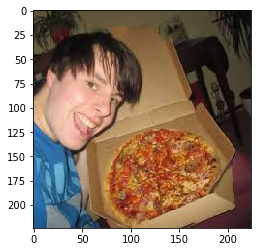

In [73]:
test = np.array(Image.open('my_test/pizza2.png').resize((224,224))).reshape(1,224,224,3)/255

print_res(model.predict(test)[0],n,test[0])

predict 1:	pizza
percentage:	42.188 %
predict 2:	lasagna
percentage:	10.384 %
predict 3:	macaroni_and_cheese
percentage:	6.733 %
predict 4:	apple_pie
percentage:	6.527 %
predict 5:	garlic_bread
percentage:	5.050 %


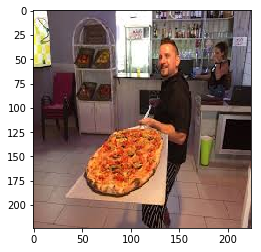

In [74]:
test = np.array(Image.open('my_test/pizza.png').resize((224,224))).reshape(1,224,224,3)/255

print_res(model.predict(test)[0],n,test[0])

It breaks in some situations:

predict 1:	poutine
percentage:	99.529 %
predict 2:	french_fries
percentage:	0.453 %
predict 3:	hot_and_sour_soup
percentage:	0.012 %
predict 4:	macaroni_and_cheese
percentage:	0.005 %
predict 5:	nachos
percentage:	0.001 %


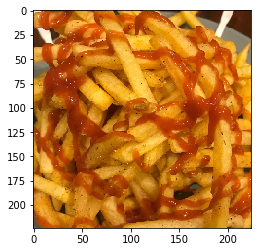

In [75]:
test = np.array(Image.open('my_test/test2.png').resize((224,224))).reshape(1,224,224,3)/255

print_res(model.predict(test)[0],n,test[0])

Time for validation

In [18]:
train_score_no_augx = model.evaluate_generator(train_generator_no_aug,train_size/batch_size)

In [19]:
val_scorex = model.evaluate_generator(validation_generator,val_size/batch_size)

In [20]:
train_scorex = model.evaluate_generator(train_generator,train_size/batch_size)

In [55]:
print('accuracy on training images: '+str(train_score_no_augx[1]))
print('loss on training images: '+str(train_score_no_augx[0]))

accuracy on training images: 0.7046205
loss on training images: 1.113277370948078


In [56]:
print('accuracy on training images with data augmentation: '+str(train_scorex[1]))
print('loss on training images augmentation: '+str(train_scorex[0]))

accuracy on training images with data augmentation: 0.6467107
loss on training images augmentation: 1.3662857912056254


In [57]:
print('accuracy on validation images: '+str(val_scorex[1]))
print('loss on validation images: '+str(val_scorex[0]))

accuracy on validation images: 0.6490099
loss on validation images: 1.4050724487493533
